# Predict learning time

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import random
import pickle
from scipy.stats import mode
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy
from scipy import stats
from one.api import ONE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

one = ONE(mode='remote')

## Get sequences per trial epoch

In [4]:
seq_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
all_sequences = pd.read_parquet(seq_path+'all_sequences_09-29-2025')
all_sequences['session'] = all_sequences['sample'].str[:36]
sess = all_sequences.session.unique()

In [5]:
design_df = all_sequences.pivot(index=['sample', 'session', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [6]:
df = design_df.copy()

## Separate states per variable (one-hot encoding)

# Intersection of states

In [7]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

# Binarize paw sequences
use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

# Append the other variables
# final_matrix = np.concatenate((binarized, licking_sequences, whisker_sequences), axis=1)
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7fddcabfd4e0>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

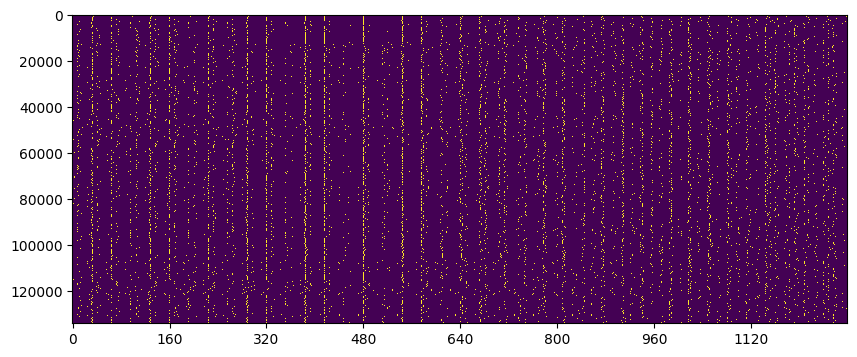

In [8]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

# Get data of interest for decoder

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=50)
X = np.array(final_matrix)
mouse_names =  pd.factorize(df['mouse_name'])[0]
session_names =  pd.factorize(df['session'])[0]
y = pd.factorize(mouse_names)[0]
X_lda = lda.fit(X, y).transform(X)


In [9]:
np.sum(lda.explained_variance_ratio_)

0.9605950587611453

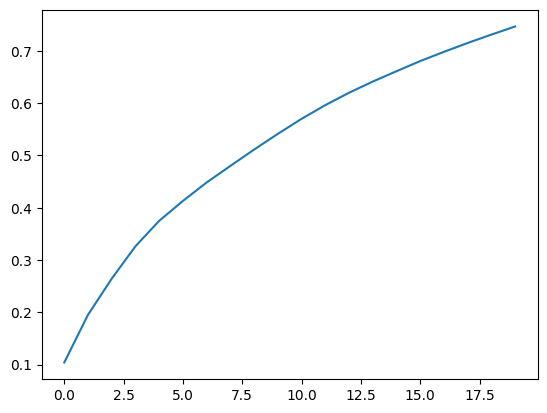

In [31]:
plt.plot(np.cumsum(lda.explained_variance_ratio_)[:20])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


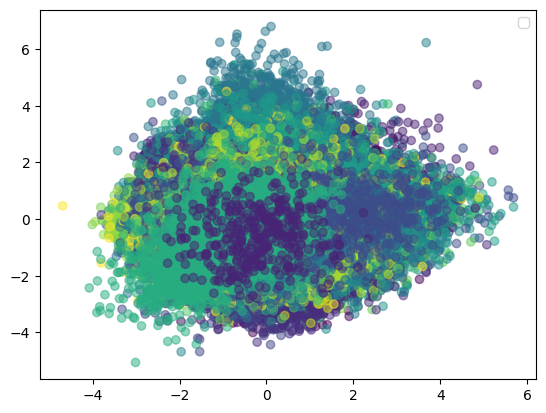

In [10]:
num_to_plot = 2000
num_to_plot = np.shape(X)[0]

plt.scatter(X_lda[:num_to_plot, 2], X_lda[:num_to_plot, 1], alpha=.5, c=y[:num_to_plot])
plt.legend()
# plt.xlim([-4, 4])
# plt.ylim([-4, 4])

In [11]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# cluster_df = pd.read_parquet(data_path+'cluster_per_session')
cluster_df = pd.read_parquet(data_path+'cluster_per_session')
cluster_df = cluster_df[['session', 'mouse_name', 'session_cluster']].reset_index()

In [13]:
clustered = pd.DataFrame(X_lda)
clustered['mouse_name'] = df['mouse_name']
clustered['session'] = df['session']

clustered = clustered.merge(cluster_df[['session', 'session_cluster']], on=['session'])

In [23]:
grouped = clustered.groupby(['mouse_name', 'session_cluster', 'session'])[[0, 1, 2, 3, 4, 5]].mean().reset_index()

(-2.0, 2.0)

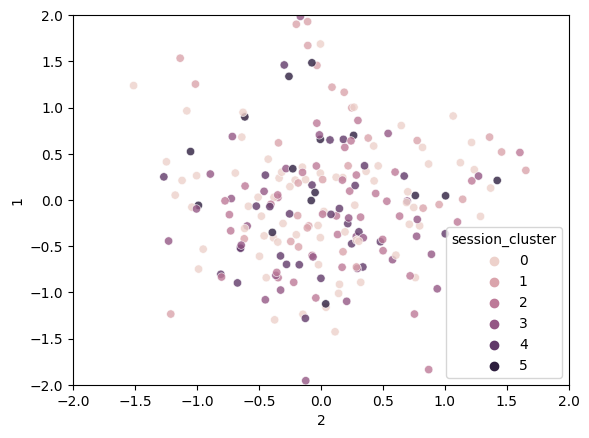

In [25]:
sns.scatterplot(x=2, y=1, hue='session_cluster', data=grouped, alpha=.8)
plt.xlim([-2, 2])
plt.ylim([-2, 2])